## Imports

In [1]:
from simtk.openmm import app
from simtk import openmm as mm
from simtk import unit

from autograd import grad
from autograd import numpy as np

## Load system

In [2]:
from openmmtools.testsystems import AlanineDipeptideVacuum

testsystem = AlanineDipeptideVacuum(constraints=None)
integrator = mm.VerletIntegrator(1*unit.femtosecond)
platform = mm.Platform.getPlatformByName("Reference")

simulation = app.Simulation(testsystem.topology, testsystem.system, integrator, platform)
xyz = testsystem.positions

simulation.context.setPositions(testsystem.positions)
flat_xyz = (xyz / unit.nanometer).flatten()

In [3]:
torsion_indices = [ 4,  6,  8, 14]

## Geometric functions

In [4]:
def compute_dihedral(xyz, indices):
    """Copied from mdtraj, except without calls to a non-python distance library,
    and assuming we dont have to deal with periodic stuff"""
    
    a,b,c,d = indices
    b1 = xyz[b] - xyz[a]
    b2 = xyz[c] - xyz[b]
    b3 = xyz[d] - xyz[c]
    
    c1 = np.cross(b2, b3) # bc x cd
    c2 = np.cross(b1, b2) # ab x bc

    p1 = np.sum(b1 * c1)
    p1 *= np.sum(b2 * b2) ** 0.5
    p2 = np.sum(c1 * c2)

    return np.arctan2(p1, p2)

In [5]:
compute_dihedral(xyz, indices=torsion_indices)

-2.356194490192345

## OpenMM utilities

In [6]:
def unflatten(flat_xyz):
    N = int(len(flat_xyz) / 3)
    return np.reshape(flat_xyz, (N, 3))

def set_positions(xyz):
    simulation.context.setPositions(xyz)
    
E_unit = simulation.context.getState(getEnergy=True).getPotentialEnergy().unit
F_unit = simulation.context.getState(getForces=True).getForces(asNumpy=True).unit
    
def get_energy(xyz):
    set_positions(xyz)
    return simulation.context.getState(getEnergy=True).getPotentialEnergy() / E_unit

def get_forces(xyz):
    set_positions(xyz)
    return simulation.context.getState(getForces=True).getForces(asNumpy=True) / F_unit

def fxn_to_minimize(flat_xyz):
    return get_energy(unflatten(flat_xyz))

def jacobian_of_fxn(flat_xyz):
    return - get_forces(unflatten(flat_xyz))

In [7]:
fxn_to_minimize(flat_xyz), jacobian_of_fxn(flat_xyz)

(-88.08858701280677,
 array([[-1.71864423e+02, -3.18532914e+01,  6.93394435e-01],
        [-2.48278095e+02, -4.06025064e+02, -2.29517355e+00],
        [-1.38636003e+01,  6.63278833e+01,  2.85953524e+01],
        [-1.53737612e+01,  6.55453841e+01, -2.69094907e+01],
        [ 4.48643201e+02,  2.27886698e+02, -1.37703175e+02],
        [ 6.63423218e+02,  4.01344211e+02, -3.88143417e+02],
        [ 8.31217545e+01,  7.90119645e+02,  2.40789269e+02],
        [-4.80724155e+01, -4.43541411e+01,  7.38061764e+00],
        [-3.89952746e+02, -3.96431950e+02, -5.37281758e+01],
        [ 4.11710161e+01,  1.08638514e+01, -5.63739208e+01],
        [-4.00936774e+01,  1.73426599e+02,  2.98724463e+02],
        [-1.77504487e+01,  2.76649439e+01,  6.28452535e+01],
        [-8.25925160e+01,  2.01081195e+02,  1.30535197e+02],
        [-4.08666997e+02, -2.61976000e+02,  3.33849426e+02],
        [ 5.72445778e+01, -1.93925032e+01, -2.79065482e+02],
        [ 2.16593317e+02,  4.39662702e+01, -8.95231210e+00],
   

## Constrained optimization using scipy

In [8]:
from functools import partial

def dihedral_constraint(flat_xyz, target_dihedral=0.0):
    """equality constraint: want the output of this function to be 0"""
    xyz = unflatten(flat_xyz)
    return compute_dihedral(xyz, torsion_indices) - target_dihedral

In [9]:
from scipy.optimize import minimize

def form_eq_constraint(target_dihedral):
    """adapted from scipy documentation
    https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#sequential-least-squares-programming-slsqp-algorithm-method-slsqp
    """
    
    fun = partial(dihedral_constraint, target_dihedral=target_dihedral)

    eq_cons = {'type': 'eq',
               'fun' : fun,
               'jac' : grad(fun)}
    return eq_cons

In [10]:
target_dihedral = - 0.5 * np.pi
target_dihedral

-1.5707963267948966

In [11]:
eq_cons = form_eq_constraint(target_dihedral)
eq_cons['jac'](flat_xyz)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        8.22110877e-06, -1.27640788e-07,  8.82319314e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -5.11681433e-06, -9.16689970e-06,
       -1.04558861e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.18988234e-05,  3.40388779e-05, -5.40978538e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.87945289e-05, -2.47443374e-05,
        7.04247833e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [12]:
from scipy.optimize import show_options
show_options('minimize', method='SLSQP')

Minimize a scalar function of one or more variables using Sequential
Least SQuares Programming (SLSQP).

Options
-------
ftol : float
    Precision goal for the value of f in the stopping criterion.
eps : float
    Step size used for numerical approximation of the Jacobian.
disp : bool
    Set to True to print convergence messages. If False,
    `verbosity` is ignored and set to 0.
maxiter : int
    Maximum number of iterations.


In [13]:
result = minimize(fxn_to_minimize, flat_xyz, method='SLSQP', jac=jacobian_of_fxn,
               constraints=[eq_cons], options={'ftol': 1e-9, 'disp': True, 'maxiter': 1000})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -116.04702111146389
            Iterations: 193
            Function evaluations: 549
            Gradient evaluations: 193


In [14]:
compute_dihedral(unflatten(result.x), torsion_indices), target_dihedral

(-1.5707963267947624, -1.5707963267948966)

# Do a torsion scan

In [15]:
# TODO: may have to define constraint not in terms of angle (skip arctan2)
torsion_grid = np.linspace(-np.pi, np.pi, 101)[1:]

In [16]:
from tqdm import tqdm
results = []
for theta in tqdm(torsion_grid):
    results.append(minimize(fxn_to_minimize, flat_xyz, method='SLSQP', jac=jacobian_of_fxn,
               constraints=[form_eq_constraint(theta)],
                            options={'ftol': 1e-9, 'disp': True, 'maxiter': 1000}))

  1%|          | 1/100 [00:00<00:35,  2.83it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -110.18031669677055
            Iterations: 127
            Function evaluations: 464
            Gradient evaluations: 127


  2%|▏         | 2/100 [00:00<00:34,  2.82it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -112.06873803491392
            Iterations: 128
            Function evaluations: 464
            Gradient evaluations: 128


  3%|▎         | 3/100 [00:01<00:35,  2.75it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -113.75638251871146
            Iterations: 132
            Function evaluations: 466
            Gradient evaluations: 132


  4%|▍         | 4/100 [00:01<00:34,  2.75it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -115.20799813955178
            Iterations: 130
            Function evaluations: 459
            Gradient evaluations: 130


  5%|▌         | 5/100 [00:01<00:34,  2.76it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -116.40033575628745
            Iterations: 131
            Function evaluations: 464
            Gradient evaluations: 131


  6%|▌         | 6/100 [00:02<00:33,  2.77it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -117.32140289920636
            Iterations: 131
            Function evaluations: 469
            Gradient evaluations: 131


  7%|▋         | 7/100 [00:02<00:33,  2.74it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -117.96907123689778
            Iterations: 134
            Function evaluations: 470
            Gradient evaluations: 134


  8%|▊         | 8/100 [00:02<00:33,  2.72it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -118.34942823923367
            Iterations: 135
            Function evaluations: 467
            Gradient evaluations: 135


  9%|▉         | 9/100 [00:03<00:34,  2.60it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -118.47529016419553
            Iterations: 140
            Function evaluations: 476
            Gradient evaluations: 140


 10%|█         | 10/100 [00:03<00:35,  2.57it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -118.36517947687858
            Iterations: 141
            Function evaluations: 480
            Gradient evaluations: 141


 11%|█         | 11/100 [00:04<00:36,  2.42it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -118.04284334203334
            Iterations: 142
            Function evaluations: 482
            Gradient evaluations: 142


 12%|█▏        | 12/100 [00:04<00:37,  2.34it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -117.53718082043231
            Iterations: 144
            Function evaluations: 484
            Gradient evaluations: 144


 13%|█▎        | 13/100 [00:05<00:37,  2.30it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -116.88234902091519
            Iterations: 145
            Function evaluations: 483
            Gradient evaluations: 145


 14%|█▍        | 14/100 [00:05<00:36,  2.34it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -116.11782346515295
            Iterations: 147
            Function evaluations: 483
            Gradient evaluations: 147


 15%|█▌        | 15/100 [00:05<00:35,  2.41it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -115.28823278603912
            Iterations: 147
            Function evaluations: 490
            Gradient evaluations: 147


 16%|█▌        | 16/100 [00:06<00:34,  2.41it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -114.4428215927291
            Iterations: 153
            Function evaluations: 493
            Gradient evaluations: 153


 17%|█▋        | 17/100 [00:06<00:34,  2.41it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -113.63439667221473
            Iterations: 155
            Function evaluations: 496
            Gradient evaluations: 155


 18%|█▊        | 18/100 [00:07<00:34,  2.40it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -112.91760458594553
            Iterations: 159
            Function evaluations: 501
            Gradient evaluations: 159


 19%|█▉        | 19/100 [00:07<00:33,  2.39it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -112.34666814000684
            Iterations: 163
            Function evaluations: 510
            Gradient evaluations: 163


 20%|██        | 20/100 [00:08<00:33,  2.37it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -111.97476960626207
            Iterations: 168
            Function evaluations: 512
            Gradient evaluations: 168


 21%|██        | 21/100 [00:08<00:33,  2.34it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -111.86888332323205
            Iterations: 174
            Function evaluations: 521
            Gradient evaluations: 174


 22%|██▏       | 22/100 [00:08<00:34,  2.28it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -112.29280900049139
            Iterations: 187
            Function evaluations: 535
            Gradient evaluations: 187


 23%|██▎       | 23/100 [00:09<00:34,  2.21it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -113.34444912986311
            Iterations: 194
            Function evaluations: 547
            Gradient evaluations: 194


 24%|██▍       | 24/100 [00:09<00:36,  2.09it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -114.66250131420202
            Iterations: 200
            Function evaluations: 552
            Gradient evaluations: 200


 25%|██▌       | 25/100 [00:10<00:36,  2.05it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -116.04702111090918
            Iterations: 193
            Function evaluations: 549
            Gradient evaluations: 193


 26%|██▌       | 26/100 [00:10<00:36,  2.00it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -117.33097322289665
            Iterations: 203
            Function evaluations: 557
            Gradient evaluations: 203


 27%|██▋       | 27/100 [00:11<00:36,  1.98it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -118.38147086872982
            Iterations: 204
            Function evaluations: 566
            Gradient evaluations: 204


 28%|██▊       | 28/100 [00:11<00:35,  2.00it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -119.10573127001174
            Iterations: 203
            Function evaluations: 559
            Gradient evaluations: 203


 29%|██▉       | 29/100 [00:12<00:35,  2.00it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -119.4475285477025
            Iterations: 206
            Function evaluations: 564
            Gradient evaluations: 206


 30%|███       | 30/100 [00:12<00:34,  2.00it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -119.37969243623337
            Iterations: 206
            Function evaluations: 561
            Gradient evaluations: 206


 31%|███       | 31/100 [00:13<00:34,  1.98it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -118.89681137784166
            Iterations: 205
            Function evaluations: 562
            Gradient evaluations: 205


 32%|███▏      | 32/100 [00:14<00:34,  1.97it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -118.00949161492974
            Iterations: 206
            Function evaluations: 566
            Gradient evaluations: 206


 33%|███▎      | 33/100 [00:14<00:34,  1.94it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -116.74034704594342
            Iterations: 208
            Function evaluations: 569
            Gradient evaluations: 208


 34%|███▍      | 34/100 [00:15<00:34,  1.91it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -115.1216384752266
            Iterations: 219
            Function evaluations: 573
            Gradient evaluations: 219


 35%|███▌      | 35/100 [00:15<00:35,  1.84it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -113.19465417328851
            Iterations: 234
            Function evaluations: 589
            Gradient evaluations: 234


 36%|███▌      | 36/100 [00:16<00:35,  1.82it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -111.01175695819875
            Iterations: 213
            Function evaluations: 566
            Gradient evaluations: 213


 37%|███▋      | 37/100 [00:16<00:34,  1.81it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -108.64467729079149
            Iterations: 230
            Function evaluations: 587
            Gradient evaluations: 230


 38%|███▊      | 38/100 [00:17<00:35,  1.75it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -106.19242380708369
            Iterations: 257
            Function evaluations: 616
            Gradient evaluations: 257


 39%|███▉      | 39/100 [00:17<00:34,  1.77it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -103.70023291559525
            Iterations: 228
            Function evaluations: 585
            Gradient evaluations: 228


 40%|████      | 40/100 [00:18<00:34,  1.72it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -101.14907253132279
            Iterations: 228
            Function evaluations: 583
            Gradient evaluations: 228


 41%|████      | 41/100 [00:19<00:33,  1.78it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.54714047188156
            Iterations: 202
            Function evaluations: 557
            Gradient evaluations: 202


 42%|████▏     | 42/100 [00:19<00:30,  1.88it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -95.92640913642907
            Iterations: 185
            Function evaluations: 536
            Gradient evaluations: 185


 43%|████▎     | 43/100 [00:20<00:29,  1.94it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -93.33065535265014
            Iterations: 186
            Function evaluations: 540
            Gradient evaluations: 186


 44%|████▍     | 44/100 [00:20<00:28,  1.99it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.80936965619827
            Iterations: 190
            Function evaluations: 543
            Gradient evaluations: 190


 45%|████▌     | 45/100 [00:21<00:28,  1.90it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -88.41391427384484
            Iterations: 223
            Function evaluations: 576
            Gradient evaluations: 223


 46%|████▌     | 46/100 [00:21<00:28,  1.91it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -86.19453522601418
            Iterations: 193
            Function evaluations: 544
            Gradient evaluations: 193


 47%|████▋     | 47/100 [00:22<00:28,  1.84it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -84.1977987765112
            Iterations: 238
            Function evaluations: 597
            Gradient evaluations: 238


 48%|████▊     | 48/100 [00:22<00:27,  1.89it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.46435751289604
            Iterations: 194
            Function evaluations: 548
            Gradient evaluations: 194


 49%|████▉     | 49/100 [00:23<00:29,  1.75it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -81.02704270042304
            Iterations: 258
            Function evaluations: 626
            Gradient evaluations: 258


 50%|█████     | 50/100 [00:23<00:28,  1.78it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -86.55496537547012
            Iterations: 211
            Function evaluations: 573
            Gradient evaluations: 211


 51%|█████     | 51/100 [00:24<00:28,  1.74it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -87.25878676283808
            Iterations: 221
            Function evaluations: 583
            Gradient evaluations: 221


 52%|█████▏    | 52/100 [00:25<00:28,  1.69it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -88.25165083092448
            Iterations: 223
            Function evaluations: 578
            Gradient evaluations: 223


 53%|█████▎    | 53/100 [00:25<00:29,  1.60it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.50940827443347
            Iterations: 211
            Function evaluations: 574
            Gradient evaluations: 211


 54%|█████▍    | 54/100 [00:26<00:28,  1.60it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -91.00111433646495
            Iterations: 222
            Function evaluations: 580
            Gradient evaluations: 222


 55%|█████▌    | 55/100 [00:27<00:27,  1.66it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -92.69370944578519
            Iterations: 212
            Function evaluations: 567
            Gradient evaluations: 212


 56%|█████▌    | 56/100 [00:27<00:26,  1.68it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -94.5588772258345
            Iterations: 222
            Function evaluations: 585
            Gradient evaluations: 222


 57%|█████▋    | 57/100 [00:28<00:25,  1.66it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -96.5748604871584
            Iterations: 214
            Function evaluations: 579
            Gradient evaluations: 214


 58%|█████▊    | 58/100 [00:29<00:29,  1.40it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.69831957933376
            Iterations: 216
            Function evaluations: 578
            Gradient evaluations: 216


 59%|█████▉    | 59/100 [00:30<00:33,  1.21it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -100.85237893320347
            Iterations: 208
            Function evaluations: 573
            Gradient evaluations: 208


 60%|██████    | 60/100 [00:31<00:31,  1.25it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -102.96063968942525
            Iterations: 209
            Function evaluations: 572
            Gradient evaluations: 209


 61%|██████    | 61/100 [00:31<00:28,  1.37it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -104.9567802887976
            Iterations: 210
            Function evaluations: 574
            Gradient evaluations: 210


 62%|██████▏   | 62/100 [00:32<00:25,  1.47it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -106.78170045032532
            Iterations: 215
            Function evaluations: 574
            Gradient evaluations: 215


 63%|██████▎   | 63/100 [00:32<00:23,  1.57it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -108.38161996825264
            Iterations: 214
            Function evaluations: 581
            Gradient evaluations: 214


 64%|██████▍   | 64/100 [00:33<00:22,  1.62it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -109.70764133080027
            Iterations: 234
            Function evaluations: 600
            Gradient evaluations: 234


 65%|██████▌   | 65/100 [00:33<00:22,  1.56it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -110.71624761857456
            Iterations: 234
            Function evaluations: 601
            Gradient evaluations: 234


 66%|██████▌   | 66/100 [00:34<00:21,  1.59it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -111.37033925123583
            Iterations: 234
            Function evaluations: 601
            Gradient evaluations: 234


 67%|██████▋   | 67/100 [00:35<00:20,  1.65it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -111.6405208131917
            Iterations: 218
            Function evaluations: 579
            Gradient evaluations: 218


 68%|██████▊   | 68/100 [00:35<00:18,  1.71it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -111.50650354528217
            Iterations: 213
            Function evaluations: 577
            Gradient evaluations: 213


 69%|██████▉   | 69/100 [00:36<00:17,  1.75it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -110.95864961252687
            Iterations: 212
            Function evaluations: 572
            Gradient evaluations: 212


 70%|███████   | 70/100 [00:36<00:16,  1.79it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -109.99977233956028
            Iterations: 207
            Function evaluations: 569
            Gradient evaluations: 207


 71%|███████   | 71/100 [00:37<00:16,  1.79it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -108.64733732768526
            Iterations: 213
            Function evaluations: 578
            Gradient evaluations: 213


 72%|███████▏  | 72/100 [00:37<00:15,  1.79it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -106.936270620382
            Iterations: 217
            Function evaluations: 581
            Gradient evaluations: 217


 73%|███████▎  | 73/100 [00:38<00:15,  1.75it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -104.92264383585302
            Iterations: 220
            Function evaluations: 586
            Gradient evaluations: 220


 74%|███████▍  | 74/100 [00:39<00:14,  1.74it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -102.68809850082462
            Iterations: 213
            Function evaluations: 575
            Gradient evaluations: 213


 75%|███████▌  | 75/100 [00:39<00:14,  1.76it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -100.3427524480961
            Iterations: 213
            Function evaluations: 576
            Gradient evaluations: 213


 76%|███████▌  | 76/100 [00:40<00:14,  1.62it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.0196260708201
            Iterations: 261
            Function evaluations: 626
            Gradient evaluations: 261


 77%|███████▋  | 77/100 [00:40<00:13,  1.66it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -95.85185932005322
            Iterations: 221
            Function evaluations: 578
            Gradient evaluations: 221


 78%|███████▊  | 78/100 [00:41<00:13,  1.67it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -93.9385144184461
            Iterations: 224
            Function evaluations: 584
            Gradient evaluations: 224


 79%|███████▉  | 79/100 [00:42<00:12,  1.65it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -92.32442219187459
            Iterations: 218
            Function evaluations: 577
            Gradient evaluations: 218


 80%|████████  | 80/100 [00:42<00:11,  1.71it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -91.00669418493464
            Iterations: 219
            Function evaluations: 577
            Gradient evaluations: 219


 81%|████████  | 81/100 [00:43<00:11,  1.68it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.95380420926847
            Iterations: 253
            Function evaluations: 623
            Gradient evaluations: 253


 82%|████████▏ | 82/100 [00:43<00:10,  1.66it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.12222965808854
            Iterations: 253
            Function evaluations: 613
            Gradient evaluations: 253


 83%|████████▎ | 83/100 [00:44<00:10,  1.65it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -88.46690267779347
            Iterations: 248
            Function evaluations: 606
            Gradient evaluations: 248


 84%|████████▍ | 84/100 [00:45<00:09,  1.65it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -87.94700030946066
            Iterations: 244
            Function evaluations: 599
            Gradient evaluations: 244


 85%|████████▌ | 85/100 [00:45<00:09,  1.61it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -87.52899316278202
            Iterations: 270
            Function evaluations: 642
            Gradient evaluations: 270


 86%|████████▌ | 86/100 [00:46<00:07,  1.77it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -86.90338347368609
            Iterations: 167
            Function evaluations: 509
            Gradient evaluations: 167


 87%|████████▋ | 87/100 [00:46<00:06,  1.92it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -87.73936241467732
            Iterations: 157
            Function evaluations: 497
            Gradient evaluations: 157


 88%|████████▊ | 88/100 [00:47<00:05,  2.02it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -88.65935874707615
            Iterations: 153
            Function evaluations: 496
            Gradient evaluations: 153


 89%|████████▉ | 89/100 [00:47<00:05,  2.11it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.64208245875092
            Iterations: 151
            Function evaluations: 495
            Gradient evaluations: 151


 90%|█████████ | 90/100 [00:47<00:04,  2.22it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.69231403578138
            Iterations: 145
            Function evaluations: 485
            Gradient evaluations: 145


 91%|█████████ | 91/100 [00:48<00:03,  2.31it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -91.828559833657
            Iterations: 142
            Function evaluations: 480
            Gradient evaluations: 142


 92%|█████████▏| 92/100 [00:48<00:03,  2.41it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -93.07707699380563
            Iterations: 137
            Function evaluations: 474
            Gradient evaluations: 137


 93%|█████████▎| 93/100 [00:48<00:02,  2.48it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -94.46623780385012
            Iterations: 130
            Function evaluations: 466
            Gradient evaluations: 130


 94%|█████████▍| 94/100 [00:49<00:02,  2.57it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -96.01987968554005
            Iterations: 123
            Function evaluations: 456
            Gradient evaluations: 123


 95%|█████████▌| 95/100 [00:49<00:01,  2.61it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -97.7499224483789
            Iterations: 129
            Function evaluations: 466
            Gradient evaluations: 129


 96%|█████████▌| 96/100 [00:50<00:01,  2.66it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -99.64991960322554
            Iterations: 127
            Function evaluations: 459
            Gradient evaluations: 127


 97%|█████████▋| 97/100 [00:50<00:01,  2.70it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -101.6919957299577
            Iterations: 125
            Function evaluations: 457
            Gradient evaluations: 125


 98%|█████████▊| 98/100 [00:50<00:00,  2.78it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -103.82876617303705
            Iterations: 119
            Function evaluations: 450
            Gradient evaluations: 119


 99%|█████████▉| 99/100 [00:51<00:00,  2.80it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.99952227741234
            Iterations: 122
            Function evaluations: 455
            Gradient evaluations: 122


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -108.10159326411431
            Iterations: 257
            Function evaluations: 1214
            Gradient evaluations: 257


In [17]:
energies = np.array([r.fun for r in results])

Text(0, 0.5, 'potential energy (kJ/mol)')

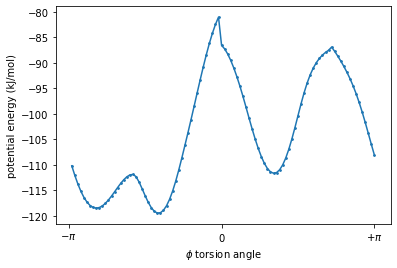

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(torsion_grid, energies)
plt.scatter(torsion_grid, energies, s=3)
plt.xlabel('$\phi$ torsion angle')
plt.xticks([-np.pi, 0, np.pi], ['$-\pi$', '$0$', '$+\pi$'])
plt.ylabel('potential energy (kJ/mol)')